# IN/OUT scan validation

Both scans at C400

**Open points**

- reduced scatter in the OUT data compared to IN --> Jose will check the mechanical movement
- the intensity correction for the new wirescanner is useless, very small correlation I/sigma

In [1]:
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/home-e/esenes/Emittance-measurement-accuracy-precision-study
Your IP is 172.17.0.7
2018-11-20 09:01:09


# User inputs

In [2]:
matlabVars = ['PR_BPM.AcquisitionOrbit.value.position', # BPMs
              'PR_BPM.AcquisitionMean.value.position',
                'PR_BPM.AcquisitionOrbit.value.channelNames',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [3]:
filenames = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.30_inscan_outscan_comparison/data/*.mat'))
myDataFrame = myToolbox.fromMatlabToDataFrame(filenames,matlabVars,verbose=False)
# manual cleanup
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:56:53.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:57:29.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:04:05.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:56:17.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:04:41.500000'].name)

# Intensity

In [4]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.mean(x[450:550]))

In [5]:
# add the intensity from TIMBER
# Alex's way
ts1 = '2018-10-30 11:07:17.000'
ts2 = '2018-09-24 14:01:42.000'

PSuser = 'CPS:MD4404_BCMS:MD7'

variables = ['PR.DCAFTINJ_1:INTENSITY']
myToolbox.addToDataFrameFromCALS(myDataFrame, variables)

WS_variables = ['PR.BWS.65.H_ROT:PROF_POSITION_IN', 'PR.BWS.65.H_ROT:PROF_DATA_IN']
myToolbox.addToDataFrameFromCALS(myDataFrame, WS_variables)

DatetimeIndex(['2018-10-30 11:07:17.500000', '2018-10-30 13:17:53.500000',
               '2018-10-30 13:32:17.500000'],
              dtype='datetime64[ns]', freq=None)


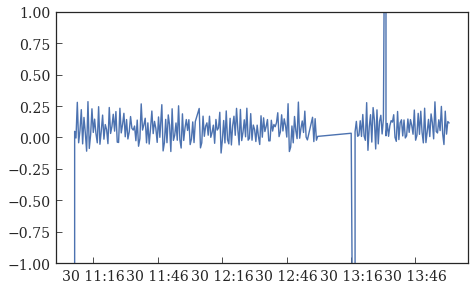

In [6]:
# check the intensity missmatch between TIMBER and MATLAB
plt.plot(myDataFrame['PR.DCAFTINJ_1:INTENSITY']-myDataFrame['Intensity'])
plt.ylim(-1,1)
idx_out_of_bounds = myDataFrame.loc[np.abs(myDataFrame['PR.DCAFTINJ_1:INTENSITY']-myDataFrame['Intensity'])>0.5].index
print(idx_out_of_bounds)

##---
myDataFrame = myDataFrame.drop(idx_out_of_bounds)

# BPMs to mm

In [7]:
myDataFrame['PR_BPM.AcquisitionOrbit.value.position'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x)
myDataFrame['PR_BPM.AcquisitionMean.value.position'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: 0.1*x)


# Process the traditional wirescanners from TIMBER

In [8]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR.BWS.65.H_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR.BWS.65.H_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

idx_to_drop = []
for r in xrange(row):
    try:
        myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR.BWS.65.H_ROT:PROF_DATA_IN'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    except:
        idx_to_drop.append(myDataFrame.iloc[r].name)

myDataFrame = myDataFrame.drop(idx_to_drop, axis=0)

#do the fit and get the sigma in mm
myDataFrame['WS65_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS65_sigma_x'] = myDataFrame['WS65_fit_results_x'].apply(lambda x: x[0][-1])
myDataFrame['WS65_mean_x'] = myDataFrame['WS65_fit_results_x'].apply(lambda x: x[0][-2])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


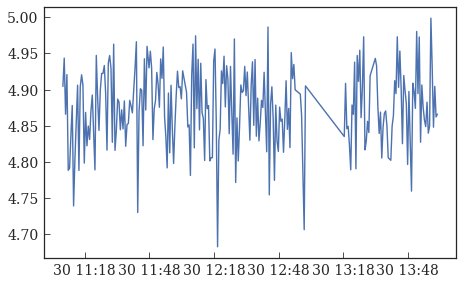

In [9]:
plt.plot(myDataFrame['WS65_sigma_x'])

(array([ 4.01283639,  0.0108442 ]), array([ 0.07093986,  0.00089163]))


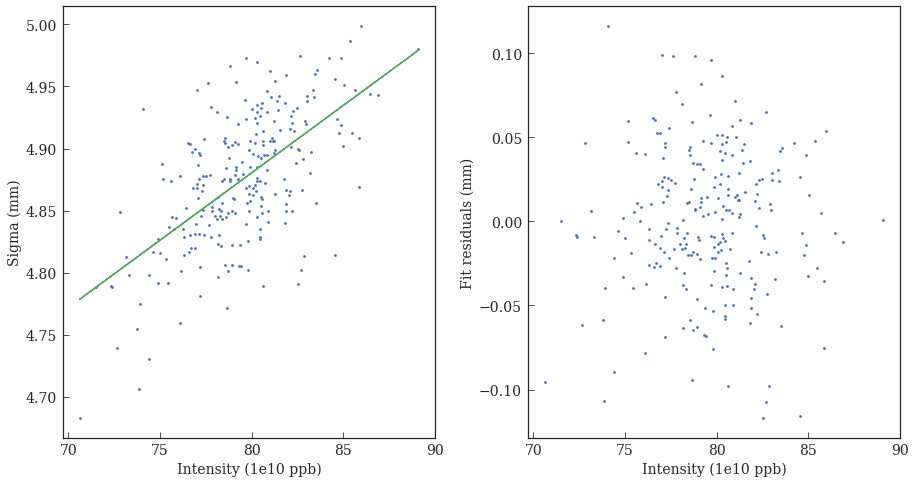

In [15]:
# intensity normalisation
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

#-----------------------------------------------
xx = myDataFrame['Intensity']
yy = myDataFrame['WS65_sigma_x']

fig, ax = plt.subplots(1,2,figsize=(13,7))
ax[0].plot(xx, yy, '.')
ax[0].set_ylabel('Sigma (mm)')
ax[0].set_xlabel('Intensity (1e10 ppb)')

popt65, pcov65 = curve_fit(lin, xx, yy)
print(popt65, np.sqrt(np.diag(pcov65)))
ax[0].plot(xx, lin(xx, *popt65))

ax[1].plot(xx, yy-lin(xx, *popt65), '.')
ax[1].set_xlabel('Intensity (1e10 ppb)')
ax[1].set_ylabel('Fit residuals (mm)')


fig.tight_layout()

We are talking of correction at the permil level .....


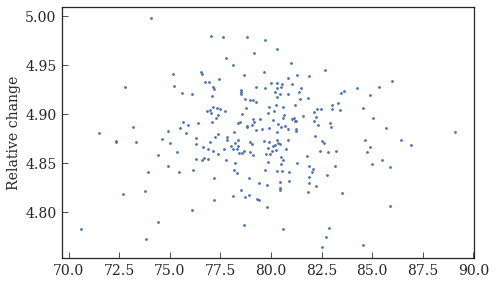

In [17]:
# intensity normalisation here @80e10 ppb
def scale_sigma(intensity, sigma, popt):
    '''
    Scale the sigma due to the Intensity of 80e10 ppb
    '''
    a = popt[0]
    b = popt[1]
    
    corr_factor = lin(intensity, a, b) / lin(80, a, b)
    return sigma/corr_factor

myDataFrame['WS65_sigmas_scaled'] = scale_sigma(myDataFrame['Intensity'], myDataFrame['WS65_sigma_x'],popt65)

plt.plot(myDataFrame['Intensity'],myDataFrame['WS65_sigmas_scaled'],'.')
plt.ylabel('Sigma_corrected')

print('We are talking of correction at the permil level .....')

# Import Jose's data

In [18]:
# import to dict
matlabVars2 = ['Sigmas_IN','Sigmas_OUT','Centres_IN','Centres_OUT','InfoData_CycleName','InfoData_AcqDelay']
new_WS_data = scipy.io.loadmat('/eos/user/e/esenes/Emittance-measurement-accuracy-precision-study/data/new_WS_in_out/Summary_Processed.mat', squeeze_me=True, struct_as_record=False)
# fix the casting for the timestamps
liuTs = []
for k in range(243):    
    ts = new_WS_data['InfoData_CycleName'][k]
    ts_unix = time.mktime(datetime.datetime.strptime(str(ts), '%Y.%m.%d.%H.%M.%S.%f').timetuple())
    liuTs.append(myToolbox.unixtime2datetime(ts_unix))
# import to dataframe
LIU_df = pnd.DataFrame([],index=liuTs)

# faulty data
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 11:28:41'].index)

# populate the dataframe
LIU_df['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['acqDelay'] = np.nan

for k, l in enumerate(LIU_df.index):
    LIU_df['Sigmas_IN'].loc[l] = new_WS_data['Sigmas_IN'][k]
    LIU_df['Sigmas_OUT'].loc[l] = new_WS_data['Sigmas_OUT'][k]
    LIU_df['Centre_IN'].loc[l] = new_WS_data['Centres_IN'][k]
    LIU_df['Centre_OUT'].loc[l] = new_WS_data['Centres_OUT'][k]
    LIU_df['acqDelay'].loc[l] = new_WS_data['InfoData_AcqDelay'][k]
    
# UTC time fix --> go all in local time
LIU_df.index = LIU_df.index + pnd.DateOffset(hours=1, milliseconds=700)

# head/tail chop
LIU_df = LIU_df.drop(LIU_df.iloc[:1].index,axis=0)
# LIU_df = LIU_df.drop(LIU_df.iloc[148:].index,axis=0)

In [19]:
# manual adjustment of the data not matching ...
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 11:40:46.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 12:56:17.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 12:56:53.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 12:57:29.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 12:59:17.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:16:05.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:17:17.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:17:53.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:31:05.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:31:41.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:32:17.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-30 13:39:29.700000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 11:12:52.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:28:05.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:28:41.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:29:17.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:42:29.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:43:41.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 12:50:17.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:18:29.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:19:41.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:20:53.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:21:29.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:22:41.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:23:53.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:29:17.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:35:53.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:37:05.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:38:53.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:40:05.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:40:41.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-30 13:41:53.500000'].name)

In [20]:
# now append !
myDataFrame['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['new_WS_acqDelay'] = np.nan

for k in range(len(myDataFrame)):
    myDataFrame['Sigmas_IN'].iloc[k] = LIU_df['Sigmas_IN'].iloc[k]
    myDataFrame['Sigmas_OUT'].iloc[k] = LIU_df['Sigmas_OUT'].iloc[k]
    myDataFrame['Centre_IN'].iloc[k] = LIU_df['Centre_IN'].iloc[k]
    myDataFrame['Centre_OUT'].iloc[k] = LIU_df['Centre_OUT'].iloc[k]
    myDataFrame['new_WS_acqDelay'].iloc[k] = LIU_df['acqDelay'].iloc[k]
    
myDataFrame['InScan'] = myDataFrame['new_WS_acqDelay']==349

In [21]:
# simplify your life ...
myDataFrame['Sigmas_IN'].loc[myDataFrame['InScan']==False] = np.nan
myDataFrame['Centre_IN'].loc[myDataFrame['InScan']==False] = np.nan
myDataFrame['Sigmas_OUT'].loc[myDataFrame['InScan']==True] = np.nan
myDataFrame['Centre_OUT'].loc[myDataFrame['InScan']==True] = np.nan


# Finally the plots

In [22]:
# data grabber for arrays with nans
def sig(x, idx):
    try:
        return x[idx]
    except:
        return x

Devsta of new WS
0.0626279469457
0.0631892279291


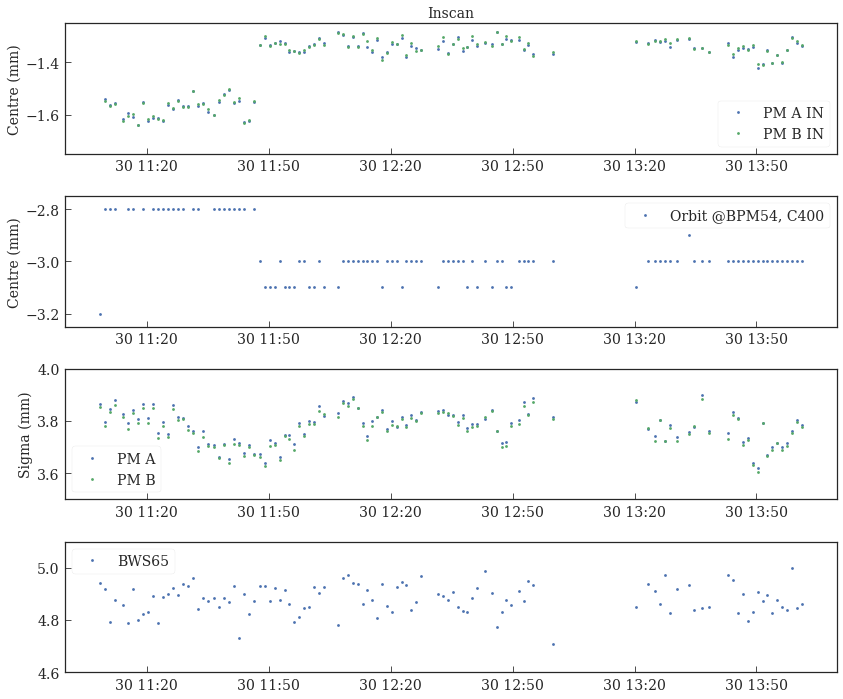

In [46]:
fig, ax = plt.subplots(4,1,figsize=(12,10))

# centres ---------------------------------------------------------
x0 = myDataFrame['Centre_IN'].loc[myDataFrame['InScan']==True].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].loc[myDataFrame['InScan']==True].apply(lambda x : sig(x,1))
# MRP @C400
mrp = myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['InScan']==True].apply(lambda x: x[0][400-170])
# Orbit @C400
orb = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].loc[myDataFrame['InScan']==True].apply(lambda x: x[22][400-170])

def print_subplot(ax_obj, row,  ydata, label, ylim=(-1.75,-1.25)):
    # plotting 
    ax_obj[row].plot( ydata,'.', label=label)
    ax_obj[row].set_ylim(ylim)
    ax_obj[row].legend(frameon=True)
    
print_subplot(ax, 0, x0, 'PM A IN')
print_subplot(ax, 0, x1, 'PM B IN')

# print_subplot(ax, 0, mrp, 'mrp' )
print_subplot(ax, 1, orb, 'Orbit @BPM54, C400' ,(-3.25,-2.75))
ax[0].set_ylabel('Centre (mm)')
ax[1].set_ylabel('Centre (mm)')

# sigmas ---------------------------------------------------------
x0 = myDataFrame['Sigmas_IN'].loc[myDataFrame['InScan']==True].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_IN'].loc[myDataFrame['InScan']==True].apply(lambda x : sig(x,1))

print_subplot(ax, 2, x0, 'PM A',(3.5,4) )
print_subplot(ax, 2, x1, 'PM B',(3.5,4) )
ax[2].set_ylabel('Sigma (mm)')

ax[0].set_title('Inscan')

print('Devsta of new WS')
print(np.std(x0))
print(np.std(x1))


# old ws ---------------------------------------------------------
x0 = myDataFrame['WS65_sigma_x'].loc[myDataFrame['InScan']==True]
print_subplot(ax, 3, x0, 'BWS65',ylim=(4.6,5.1) )


fig.tight_layout()

Devsta of new WS
0.038295292052
0.0396943987352


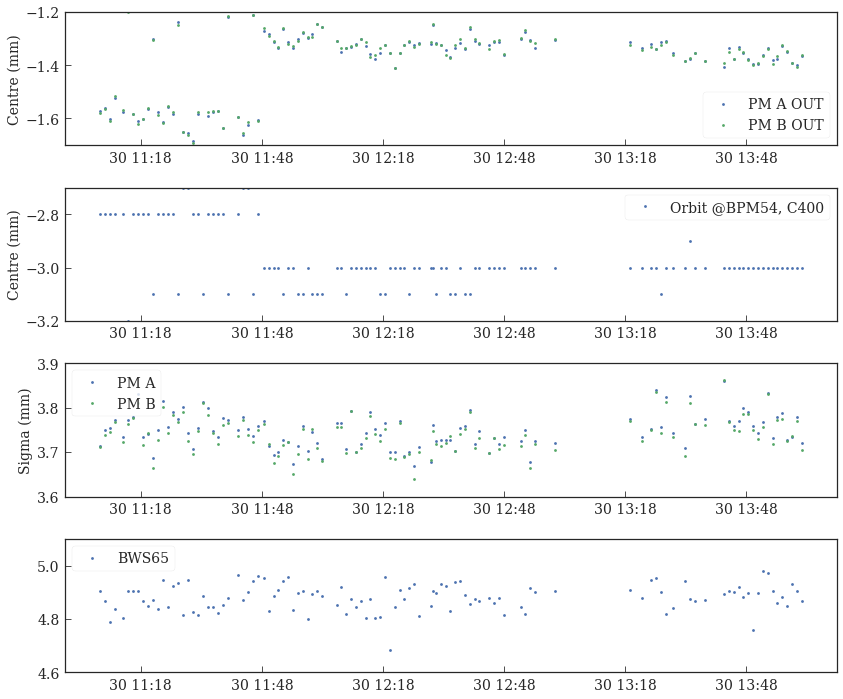

In [48]:
fig, ax = plt.subplots(4,1,figsize=(12,10))

# centres ---------------------------------------------------------
x0 = myDataFrame['Centre_OUT'].loc[myDataFrame['InScan']==False].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_OUT'].loc[myDataFrame['InScan']==False].apply(lambda x : sig(x,1))
# MRP @C400
mrp = myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['InScan']==False].apply(lambda x: x[0][400-170])
# Orbit @C400
orb = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].loc[myDataFrame['InScan']==False].apply(lambda x: x[22][400-170])

def print_subplot(ax_obj, row,  ydata, label, ylim=(-5,5)):
    # plotting 
    ax_obj[row].plot( ydata,'.', label=label)
    ax_obj[row].set_ylim(ylim)
    ax_obj[row].legend(frameon=True)
    
print_subplot(ax, 0, x0, 'PM A OUT')
print_subplot(ax, 0, x1, 'PM B OUT',(-1.7,-1.2))

# print_subplot(ax, 0, mrp, 'mrp' )
print_subplot(ax, 1, orb, 'Orbit @BPM54, C400' ,(-3.2,-2.7))
ax[0].set_ylabel('Centre (mm)')
ax[1].set_ylabel('Centre (mm)')

# sigmas ---------------------------------------------------------
x0 = myDataFrame['Sigmas_OUT'].loc[myDataFrame['InScan']==False].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_OUT'].loc[myDataFrame['InScan']==False].apply(lambda x : sig(x,1))

print_subplot(ax, 2, x0, 'PM A')
print_subplot(ax, 2, x1, 'PM B',(3.6,3.9) )
ax[2].set_ylabel('Sigma (mm)')

print('Devsta of new WS')
print(np.std(x0))
print(np.std(x1))


# old ws ---------------------------------------------------------
x0 = myDataFrame['WS65_sigma_x'].loc[myDataFrame['InScan']==False]
print_subplot(ax, 3, x0, 'BWS65',ylim=(4.6,5.1) )




fig.tight_layout()


# Intensity correction

(array([  3.54000987e+00,   2.80952599e-03]), array([ 0.09462673,  0.00119057]))


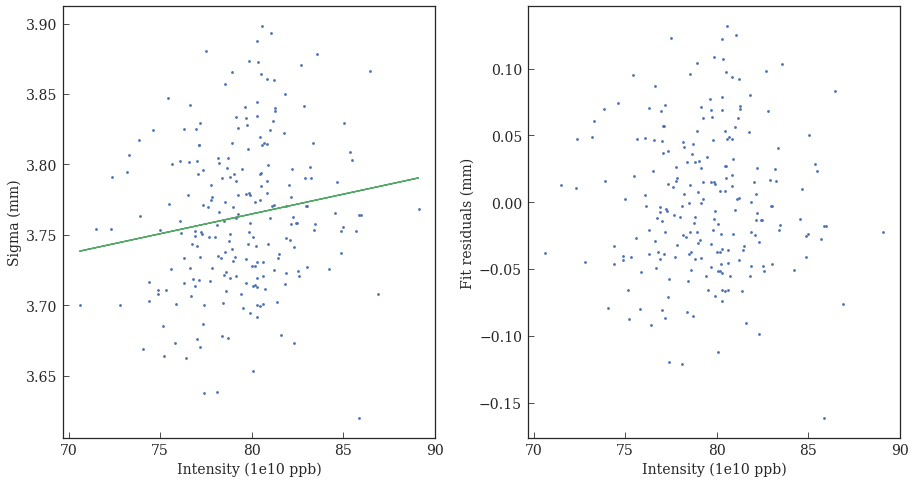

In [25]:
# kill bad shots
# PM1
yy = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,0))
myDataFrame = myDataFrame.drop(myDataFrame.loc[yy<2].index, axis=0)
# PM2
yy = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,0))
myDataFrame = myDataFrame.drop(myDataFrame.loc[yy<2].index, axis=0)

# build a single list of sigmas either with sigma in or out
def nans_to_zero(x):
    if np.isnan(x):
        return 0
    else:
        return x
y1 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,0))
y1 = y1.apply(lambda x: nans_to_zero(x))
y2 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,0))
y2 = y2.apply(lambda x: nans_to_zero(x))
myDataFrame['Sigmas_overall'] = y1+y2

#-----------------------------------------------------------------------
# now plot !
xx = myDataFrame['Intensity']
yy = myDataFrame['Sigmas_overall']

fig, ax = plt.subplots(1,2,figsize=(13,7))
ax[0].plot(xx, yy, '.',label='IN scan, PMA')
ax[0].set_ylabel('Sigma (mm)')
ax[0].set_xlabel('Intensity (1e10 ppb)')

popt, pcov = curve_fit(lin, xx, yy)
print(popt, np.sqrt(np.diag(pcov)))
ax[0].plot(xx, lin(xx, *popt))

ax[1].plot(xx, yy-lin(xx, *popt), '.')
ax[1].set_xlabel('Intensity (1e10 ppb)')
ax[1].set_ylabel('Fit residuals (mm)')


fig.tight_layout()

We are talking of correction at the permil level .....


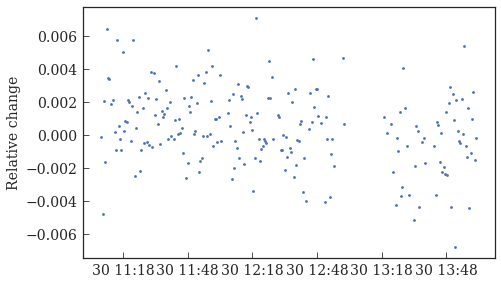

In [26]:
# intensity normalisation here @80e10 ppb
def scale_sigma(intensity, sigma, popt):
    '''
    Scale the sigma due to the Intensity of 80e10 ppb
    '''
    a = popt[0]
    b = popt[1]
    
    corr_factor = lin(intensity, a, b) / lin(80, a, b)
    return sigma/corr_factor

myDataFrame['Sigmas_overall_scaled'] = scale_sigma(myDataFrame['Intensity'], myDataFrame['Sigmas_overall'],popt)

plt.plot((myDataFrame['Sigmas_overall_scaled']-myDataFrame['Sigmas_overall'])/myDataFrame['Sigmas_overall'],'.')
plt.ylabel('Relative change')

print('We are talking of correction at the permil level .....')

In [130]:
# To be done
- take the inscans and the outscans separately and calculate the correction curves to be compared to Jose's

SyntaxError: invalid syntax (<ipython-input-130-e5c8dcbf2e37>, line 2)

(array([  3.57023366e+00,   2.62230804e-03]), array([ 0.15474802,  0.00194374]))


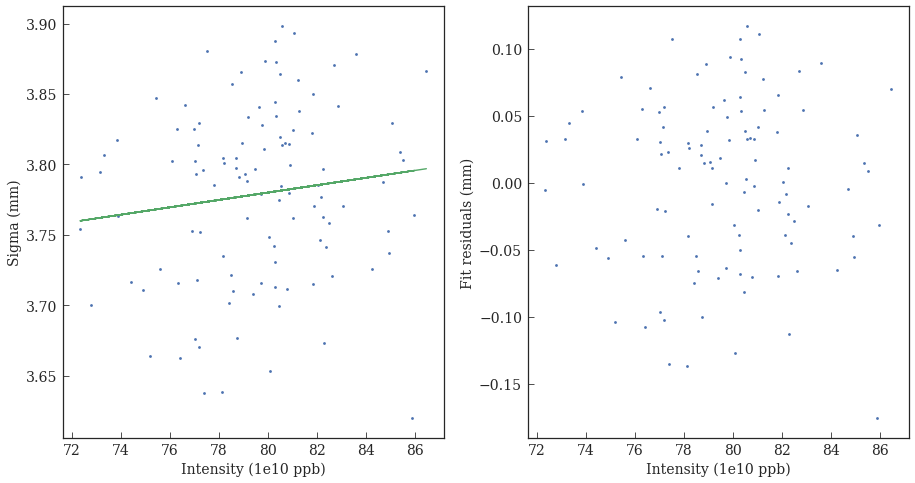

In [72]:
# inscans
xx = myDataFrame['Intensity']
yy = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,0))
selector=~np.isnan(yy)#bool array
xx = xx[selector]
yy = yy[selector]

fig, ax = plt.subplots(1,2,figsize=(13,7))
ax[0].plot(xx, yy, '.',label='IN scan, PMA')
ax[0].set_ylabel('Sigma (mm)')
ax[0].set_xlabel('Intensity (1e10 ppb)')

popt, pcov = curve_fit(lin, xx, yy)
print(popt, np.sqrt(np.diag(pcov)))
ax[0].plot(xx, lin(xx, *popt))

ax[1].plot(xx, yy-lin(xx, *popt), '.')
ax[1].set_xlabel('Intensity (1e10 ppb)')
ax[1].set_ylabel('Fit residuals (mm)')


fig.tight_layout()